In [1]:
import pandas as pd
from Bio import SeqIO
from seaborn import histplot
from Bio.Align.Applications import ClustalwCommandline
from Bio import AlignIO
from tqdm.notebook import tqdm
import os
import pickle
inputFile = '../raw_data/SGD_all_ORFs_3prime_UTRs.fsa'
rawDataP1 = pd.read_excel('../raw_data/yamanishi/sb300116y_si_002.xls', skiprows=1)
rawDataP2 = pd.read_excel('../raw_data/41592_2018_45_MOESM4_ESM.xlsx', skiprows=6)


/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Merge the two dataframes information about gene and systematic names

In [2]:
# systematic names in rawDataP2 but not in rawDataP1
systematicNameDiff = rawDataP2[~rawDataP2['Systematic Name'].isin(rawDataP1['Systematic Name'])]
systematicNameDiff

,Systematic Name,Standard Name,intensity,fold_bkg,intensity.1,fold_bkg.1,intensity.2,fold_bkg.2
8,YAL014C,SYN8,0.010805,1.526316,0.015127,1.736842,0.040246,3.575758
10,YAL016C-B,NaN,0.001692,1.066667,0.005076,1.200000,0.001694,1.076923
24,YAL033W,POP5,0.027778,2.551724,0.029630,2.655172,0.014610,1.612903
28,YAL037C-A,NaN,0.012313,1.636364,0.022867,2.181818,NaN,NaN
35,YAL045C,NaN,0.008460,1.270270,0.007614,1.243243,0.009318,1.379310
...,...,...,...,...,...,...,...,...
5214,YPR158W,CUR1,0.002460,1.111111,0.005535,1.250000,0.009184,1.548387
5223,YPR169W-A,NaN,0.200000,15.884615,0.337984,26.153846,0.120946,10.891304
5224,YPR170C,NaN,0.018335,1.923077,0.041762,3.102564,0.002723,1.205882
5225,YPR170W-A,NaN,0.003101,1.157895,0.005685,1.289474,0.003721,1.200000


In [3]:
systematicNameDiff['Standard Name'].isin(rawDataP1['Gene Name']).any() # good, this must be false

False

In [4]:
data = rawDataP1[['Systematic Name', 'Gene Name', 'Sequence of amplified region']].append(systematicNameDiff[['Systematic Name', 'Standard Name']].rename(
    columns={'Standard Name':'Gene Name'}))

Access downloaded Fasta file and retrieved UTR-3' sequences. Perform multiple alignment.

In [5]:
fasta_sequences = list(SeqIO.parse(open(inputFile),'fasta').records)

In [7]:
utrs = {}
seqs = {}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    gene = name.split('_')[4]
    _id = int(name.split('_')[5][2:])
    if _id not in utrs:
        utrs[_id] = {}
    utrs[_id][gene] = sequence
    

In [8]:
# # Alignment
# aligned = {}
# for gene in tqdm(seqs):
#     if len(seqs[gene]) == 1:
#         aligned[gene] = seqs[gene]
#         continue
#     with open("tmp.fst", "w")  as out:
#         SeqIO.write(seqs[gene],out, 'fasta')
#     try:
#         cmd = ClustalwCommandline("./clustalw2", infile="tmp.fst")
#         stdout, stderr = cmd()
#     except:
#         try:
#             cmd = ClustalwCommandline("clustalw2", infile="tmp.fst")
#             stdout, stderr = cmd()
#         except:
#             print("clustalw2 needs to be installed!")
#             raise
#     finally:
#         os.remove('tmp.fst')
#     try:
#         aligned[gene] = AlignIO.read("tmp.aln", "clustal")
#     finally:
#         os.remove('tmp.aln')

In [9]:
len(utrs)

29

In [10]:
seqLengths = {k: len(v) for k,v in utrs[1].items()}

<AxesSubplot:xlabel="UTR3' length", ylabel='Count'>

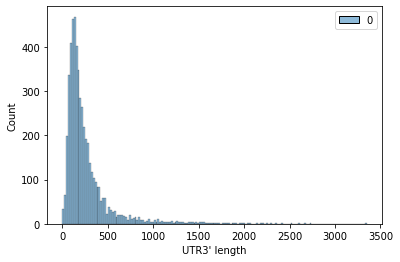

In [11]:

ax = histplot(seqLengths.values())
ax.set(xlabel='UTR3\' length')
ax

In [12]:
pd.DataFrame(utrs).isnull().sum()

1         0
6      5064
3      4136
14     5208
2      2955
4      4678
5      4938
8      5171
7      5126
9      5181
12     5206
10     5192
22     5209
16     5208
15     5208
11     5196
19     5210
23     5210
60     5210
13     5205
34     5209
20     5209
30     5209
18     5209
44     5210
21     5210
685    5210
27     5210
17     5209
dtype: int64

In [13]:
foreign = pd.DataFrame({'foreign':utrs[1]})
foreign.reset_index(inplace=True)
foreign.rename(columns={'index':'Systematic Name'}, inplace=True)
foreign.head()

,Systematic Name,foreign
0,YAL002W,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
1,YAL003W,AAAGGCTTTTTTATAAACTTTTTATAATTAACATTAAAGCAAAAAC...
2,YAL004W,AATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTGAA...
3,YAL005C,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
4,YAL007C,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...


**Outer** merge sequences information to the knows ones

In [14]:
updated = data.merge(foreign, on=['Systematic Name'], how='outer')
updated.head()

,Systematic Name,Gene Name,Sequence of amplified region,foreign
0,Q0050,AI1,TTAATGATACTCAATATGGAAAGCCGTATGATGGGAAACTATCACG...,NaN
1,Q0055,AI2,TATTAAATATGCGTTAAATGGAGAGCCGTATGATATGAAAGTATCA...,NaN
2,Q0060,AI3,AATTATTATTACTTTCTTCCCCTCCGAATCCGTAATATATTTACGG...,NaN
3,YAL001C,TFC3,ACATAATGAAATGAGGTGTATAAATTTTACTTTTATGTAACCAAAG...,NaN
4,YAL002W,VPS8,TTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCAT...,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...


In [15]:
updated.rename(columns={'Sequence of amplified region':'orig'}, inplace=True)

In [16]:
updated['updated'] = updated['foreign'].fillna(updated['orig'])
updated = updated.dropna(subset=['updated'])

<AxesSubplot:xlabel="UTR3' length", ylabel='Count'>

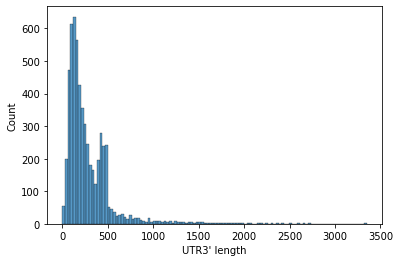

In [17]:
ax = histplot(updated['updated'].apply(len))
ax.set(xlabel='UTR3\' length')
ax

In [18]:
updated['updated'].isnull().any()

False

In [19]:
output = updated[['Systematic Name', 'Gene Name', 'orig', 'foreign']]

In [20]:
output.to_csv('../processed_data/utrs.csv', index=None)

Output file **contains nans in all rows** except for the Systematic Name

In [21]:
(~output.isnull()).sum()

Systematic Name    5833
Gene Name          5492
orig               5302
foreign            5211
dtype: int64

In [22]:
(~output[~output['Gene Name'].isnull()].isnull()).sum()

Systematic Name    5492
Gene Name          5492
orig               5302
foreign            4870
dtype: int64